# Convolutional Neural Network

Implement an image classifier using a deep learning network. You are given colour images of 224 by 224 pixels, containing 15 types of vegetables. 

You must convert the given images into grayscale (i.e. only 1 channel instead of 3). Consider two different input sizes:  
    a) 31 by 31 pixels 
    b) 128 by 128 pixels  
    
Do not use the original size of 224 by 224 pixels. Build two types of neural networks, one for each input size. Compare and discuss the classification accuracies for each input size. 

[Original Dataset](https://www.kaggle.com/datasets/misrakahmed/vegetable-image-dataset) <br>
Ahmed, M.I., Mahmud Mamun, S. and Zaman Asif, A.U. (2021) ‘DCNN-based vegetable image classification using Transfer learning: A comparative study’, 2021 5th International Conference on Computer, Communication and Signal Processing (ICCCSP) [Preprint]. doi:10.1109/icccsp52374.2021.9465499. 

In [2]:
import os
from tqdm.notebook import tqdm
import random
import warnings
import pickle
import json

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Disable TF Warnings
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ["tf_gpu_allocator"]="cuda_malloc_async"
warnings.filterwarnings("ignore")

checkpoint_folder_path = "training_checkpoints/"

# example filepath large_weights.{epoch:02d}-{val_loss:.2f}.hdf5

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_colwidth', None)

import tensorflow as tf

print(tf.config.list_physical_devices('GPU'))
# physical_devices = tf.config.experimental.list_physical_devices('GPU')

# if len(physical_devices) > 0:
#     tf.config.experimental.set_memory_growth(physical_devices[0], True)

import visualkeras

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
!nvidia-smi

Mon Nov 27 00:14:28 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.06              Driver Version: 535.98       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4070        On  | 00000000:01:00.0  On |                  N/A |
|  0%   36C    P5              22W / 200W |  11728MiB / 12282MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [5]:
import cv2

In [6]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, SpatialDropout2D, ReLU, LeakyReLU, BatchNormalization, Add, Input, concatenate
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import RandomCrop, RandomContrast, RandomFlip, RandomRotation, RandomTranslation, RandomZoom, Resizing, Rescaling

from tensorflow.keras.regularizers import L1, L2, L1L2
from tensorflow.keras.utils import to_categorical, plot_model, image_dataset_from_directory
from tensorflow.keras.optimizers.schedules import ExponentialDecay, PiecewiseConstantDecay
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.saving import load_model

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report

In [7]:
sns.set(style='darkgrid', palette='deep')

tf.random.set_seed(42)

# Exploratory Data Analysis

The dataset consists of labelled images of vegetables including:
* Bean
* Bitter_Gourd
* Bottle_Gourd
* Brinjal
* Broccoli
* Cabbage
* Capsicum
* Carrot
* Cauliflower
* Cucumber
* Papaya
* Potato
* Pumpkin
* Radish
* Tomato

Provided are a train set (inconsistent number of samples for each class), a train set (200 samples/class), and a validation set (200 samples/class).

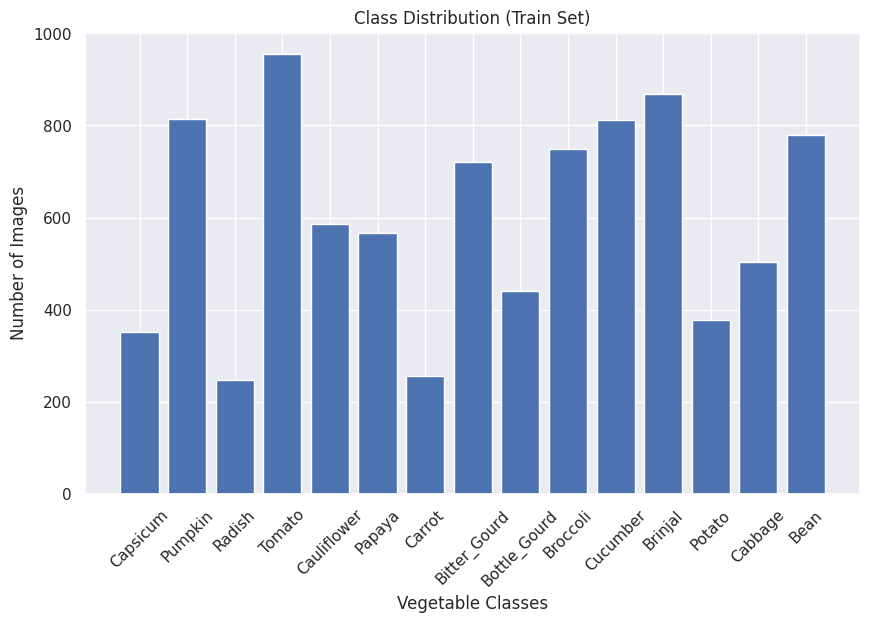

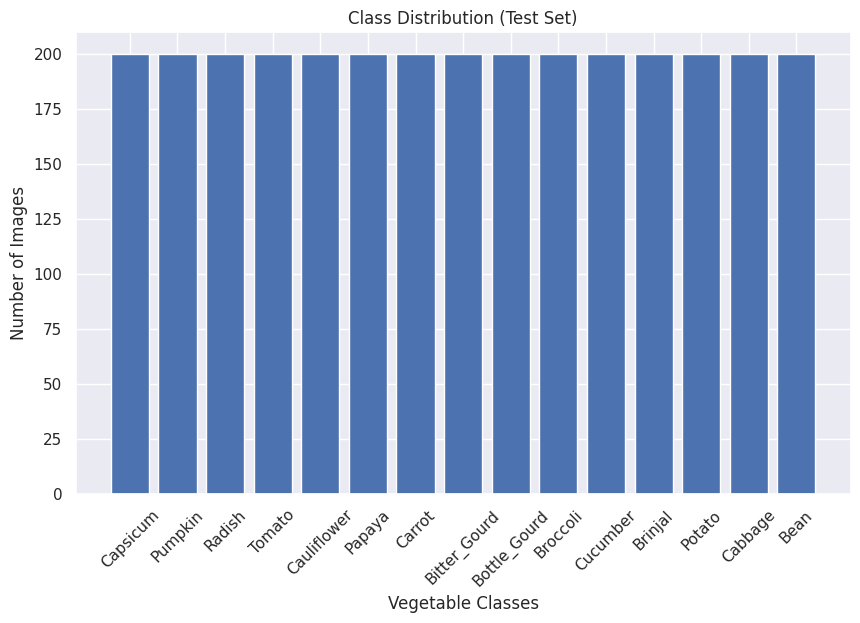

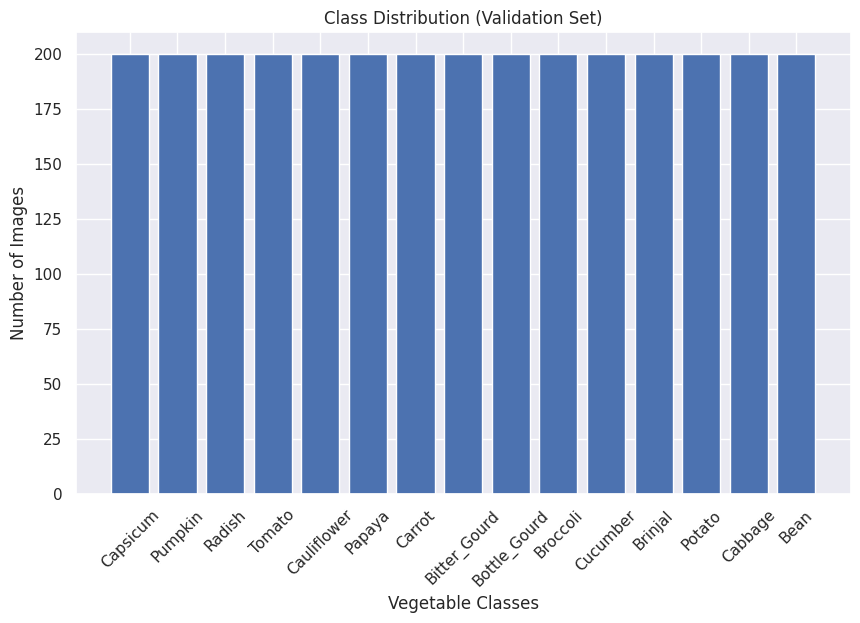

In [10]:
def plot_class_count_dir(dir, train):
    # Count the number of images in each class
    class_counts = {}
    for subdir, _, files in os.walk(dir):
        if subdir.split("/")[-1] != "":
            class_counts[subdir.split("/")[-1]] = len(files)
    
    # Plot class distribution
    plt.figure(figsize=(10, 6))
    plt.bar(class_counts.keys(), class_counts.values())
    plt.xlabel('Vegetable Classes')
    plt.ylabel('Number of Images')
    plt.title(train)
    plt.xticks(rotation=45)
    plt.show()

plot_class_count_dir('Vegetable Images/train/', 'Class Distribution (Train Set)')
plot_class_count_dir('Vegetable Images/test/', 'Class Distribution (Test Set)')
plot_class_count_dir('Vegetable Images/validation/', 'Class Distribution (Validation Set)')

* Imbalanced Dataset
* Will have to via adjusting class weights, penalising the model more for incorrect classification of lower frequency class

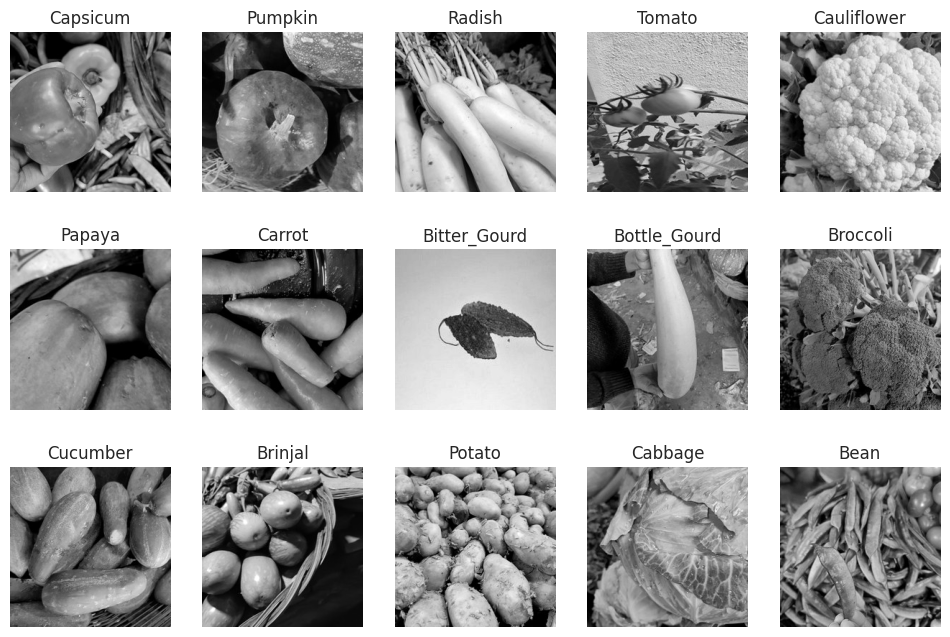

In [11]:
plt.figure(figsize=(12, 8))
for i in range(15):
    subdir = os.listdir('Vegetable Images/train/')[i]
    img_file = random.choice(os.listdir(os.path.join('Vegetable Images/train/', subdir)))
    img_path = os.path.join('Vegetable Images/train', subdir, img_file)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    plt.subplot(3, 5, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(subdir)
    plt.axis('off')
plt.show()

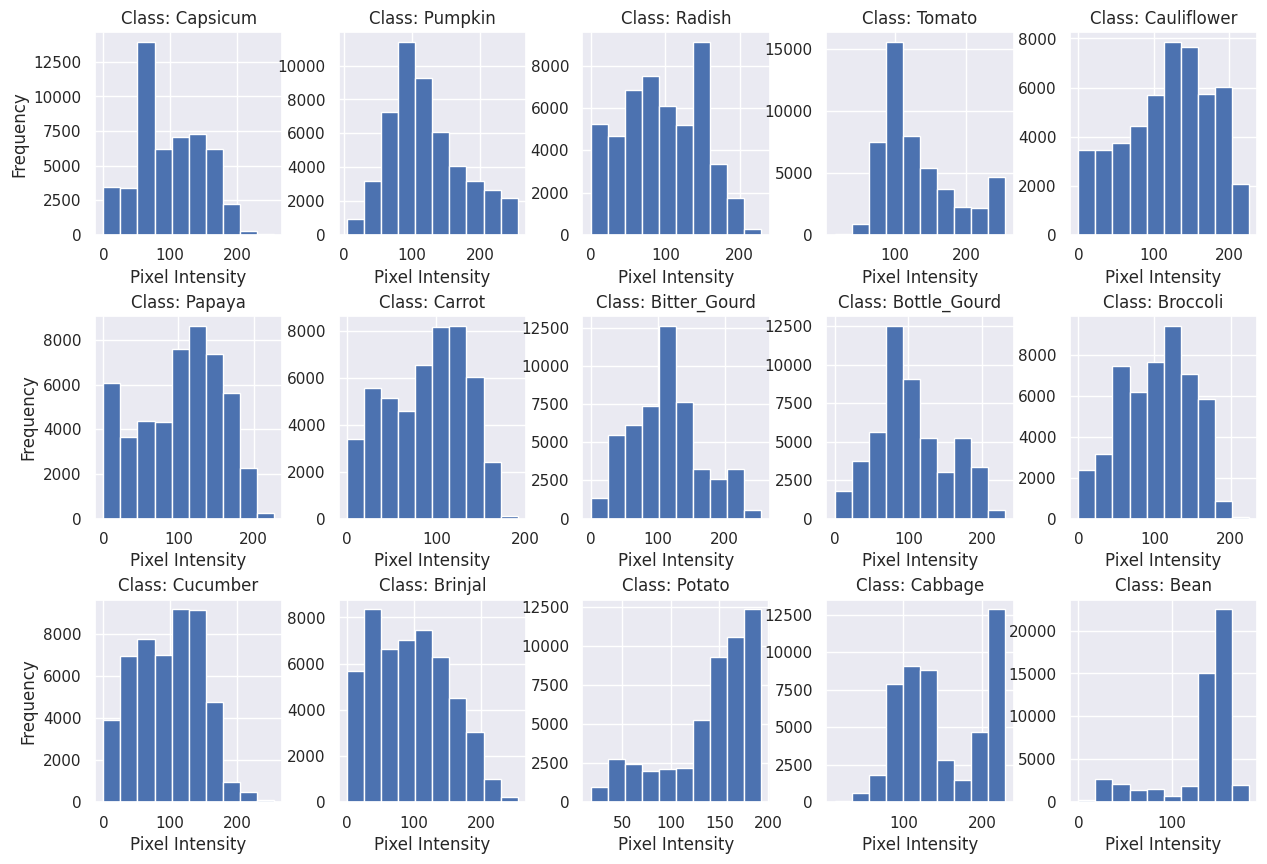

In [12]:
def plot_intensity_histogram(image_path, class_name, ax):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    ax.hist(img.ravel())
    ax.set_xlabel('Pixel Intensity')
    ax.set_title(f'Class: {class_name}')
    return ax

fig, axes = plt.subplots(3, 5, figsize=(15, 10))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

class_folders = os.listdir('Vegetable Images/train/')
for i, class_folder in enumerate(class_folders):
    sample_image_path = os.path.join('Vegetable Images/train/', class_folder, os.listdir(f'Vegetable Images/train/{class_folder}')[0])
    row = i // 5
    col = i % 5
    ax = plot_intensity_histogram(sample_image_path, class_folder, axes[row, col])
    if col == 0:
        ax.set_ylabel('Frequency')

plt.show()

In [10]:
class_keys = {
    "Bean": 0,
    "Bitter_Gourd": 1,
    "Bottle_Gourd": 2,
    "Brinjal": 3,
    "Broccoli": 4,
    "Cabbage": 5,
    "Capsicum": 6,
    "Carrot": 7,
    "Cauliflower": 8,
    "Cucumber": 9,
    "Papaya": 10,
    "Potato": 11,
    "Pumpkin": 12,
    "Radish": 13,
    "Tomato": 14
}

inverted_class_keys = {v: k for k, v in class_keys.items()}

In [11]:
train_dir = 'Vegetable Images/train/'
test_dir = 'Vegetable Images/test/'
validation_dir = 'Vegetable Images/validation/'

In [12]:
train = image_dataset_from_directory(train_dir, batch_size=None, image_size=(224, 224), color_mode="grayscale", label_mode="categorical")
test = image_dataset_from_directory(test_dir, batch_size=None, image_size=(224, 224), color_mode="grayscale", label_mode="categorical")
validation = image_dataset_from_directory(validation_dir, batch_size=None, image_size=(224, 224), color_mode="grayscale", label_mode="categorical")

Found 9028 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.


## Preprocessing: Data Augmentation 
#### Reasoning:
* Data augmentation effectively increases the size of the training dataset. With more diverse examples, the model can learn a broader range of patterns and become more robust. Especially with some classes only having about 200 training samples.
* Model will be more generalized and reduces overfitting from memorizing specific examples.

In [13]:
# extremely slow in TF 2.10.0, can slow model as much as 6x

prep = Sequential(
    [
        Rescaling(1./255),
    ],
    name="preprocessing"
)

image_augmentation = Sequential(
    [
        RandomFlip("horizontal_and_vertical"),
        RandomContrast(0.3),
        RandomRotation((-0.35, 0.35)),
        RandomZoom(0.2, 0.2)
    ],
    name="image_augmentation"
)

def resize_small(image, label):
    return Resizing(31, 31)(image), label

def resize_large(image, label):
    return Resizing(128, 128)(image), label

# train_single_channel = train.map(expand_dims)
# validation_single_channel = validation.map(expand_dims)
# test_single_channel = test.map(expand_dims)

small_train = train.map(resize_small)
small_validation = validation.map(resize_small)
small_test = test.map(resize_small)

large_train = train.map(resize_large)
large_validation = validation.map(resize_large)
large_test = test.map(resize_large)

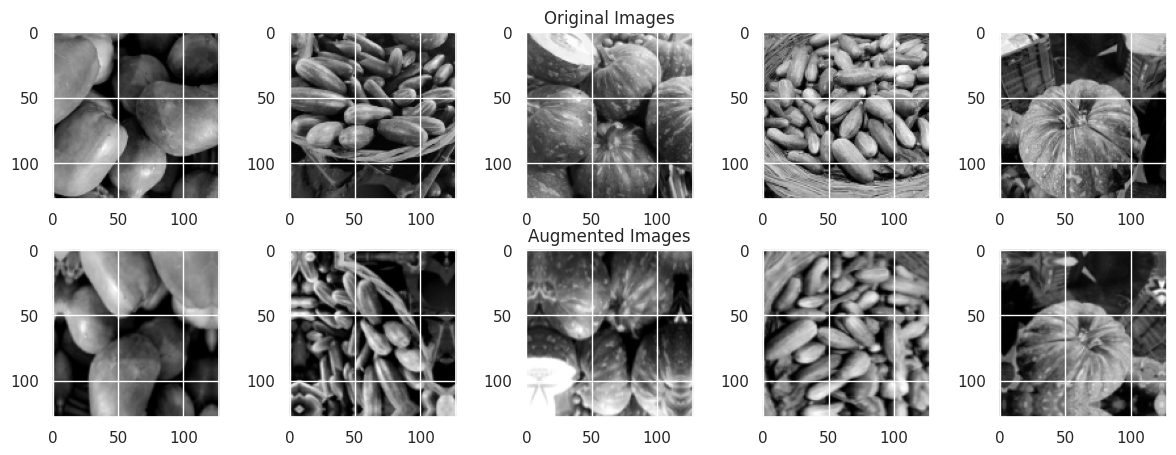

In [18]:
fig, axes = plt.subplots(2, 5, figsize=(15, 5))

# axes = np.flatten(axes)
plt.subplots_adjust(hspace=0.3, wspace=0.1)

for i, (image, label) in enumerate(large_train.take(5)):
    axes[0][i].imshow(image, cmap="gray")
    axes[1][i].imshow(image_augmentation(image), cmap="gray")
    
    
axes[0][2].set_title("Original Images")
axes[1][2].set_title("Augmented Images")
    
plt.show()

This data augmentation is added as a preprocessing layer in the model and applied during model training.

### Calculating Class Weights

In [19]:
class_series = np.argmax([label for (_, label) in train.take(9028)], axis=1)
class_labels = np.unique(class_series)
class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=class_series)
class_weights = dict(zip(class_labels, class_weights))
print(class_weights)

{0: 0.7716239316239316, 1: 0.835925925925926, 2: 1.3647770219198792, 3: 0.693394777265745, 4: 0.8024888888888889, 5: 1.1965540092776674, 6: 1.7147198480531813, 7: 2.3510416666666667, 8: 1.0253265190232823, 9: 0.7412151067323481, 10: 1.0633686690223794, 11: 1.5964633068081344, 12: 0.7393939393939394, 13: 2.4268817204301074, 14: 0.6302268760907505}


Classes with the lowest sample count in the training set will have the greatest weight eg. 13: Radish

## 128x128 Model

In [20]:
def plot_history(history, title, savefig=""):
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    fig.suptitle(title)
    
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy')
    
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    
    left_legend = []
    for k, v in history.items():
        ax[0].plot(v.history['accuracy'])
        ax[0].plot(v.history['val_accuracy'])
        left_legend += [f'{k} Train', f'{k} Validation']
    ax[0].legend(left_legend, loc='lower right')
    
    right_legend = []
    for k, v in history.items():
        ax[1].plot(v.history['loss'])
        ax[1].plot(v.history['val_loss'])
        right_legend += [f'{k} Train', f'{k} Validation']
    ax[1].legend(right_legend, loc='upper left')
    
    plt.tight_layout()

    if savefig != "":
        fig.savefig(savefig, bbox_inches='tight')
    plt.show()

In [21]:
def fit_model(model, train, val, test, batch_size=32, epochs=50, callbacks = [], filepath=""):
    # model.summary()
    if filepath != "":
        cp_callback = ModelCheckpoint(filepath=filepath, save_weights_only=True, save_best_only=True, verbose=1, save_freq='epoch')
        
        history = model.fit(
            train.batch(batch_size),
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(val.batch(batch_size)),
            callbacks=[cp_callback] + callbacks
        )
    else:
        history = model.fit(
            train.batch(batch_size),
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(val.batch(batch_size)),
            callbacks=callbacks
        )
    
    accuracy = model.evaluate(test.batch(batch_size), verbose=0)[1]
    
    print(f"Accuracy for images: {accuracy:.2f}")

    return history

## Comparing Class Imbalance Compensation Methods
* Class Weights
* Image Augmentation

In [21]:
simple_CNN_history = {}

simple_CNN_no_class_weights = Sequential([
    prep,
    Conv2D(32, (5, 5), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(500, activation='relu'),
    Dense(500, activation='relu'),
    # Dropout(0.3),
    Dense(15, activation='softmax')
])

# Compile the model
simple_CNN_no_class_weights.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

simple_CNN_history["Without CW"] = fit_model(simple_CNN_no_class_weights, large_train, large_validation, large_test)

Epoch 1/50
283/283 [==============================] - 9s 14ms/step - loss: 2.0168 - accuracy: 0.3559 - val_loss: 1.5047 - val_accuracy: 0.5327
Epoch 2/50
283/283 [==============================] - 3s 12ms/step - loss: 0.9419 - accuracy: 0.7044 - val_loss: 1.0198 - val_accuracy: 0.6793
Epoch 3/50
283/283 [==============================] - 3s 12ms/step - loss: 0.3520 - accuracy: 0.8897 - val_loss: 0.8393 - val_accuracy: 0.7583
Epoch 4/50
283/283 [==============================] - 3s 12ms/step - loss: 0.1216 - accuracy: 0.9621 - val_loss: 1.0210 - val_accuracy: 0.7410
Epoch 5/50
283/283 [==============================] - 3s 12ms/step - loss: 0.0541 - accuracy: 0.9847 - val_loss: 1.2176 - val_accuracy: 0.7680
Epoch 6/50
283/283 [==============================] - 3s 12ms/step - loss: 0.0472 - accuracy: 0.9874 - val_loss: 1.2563 - val_accuracy: 0.7473
Epoch 7/50
283/283 [==============================] - 4s 12ms/step - loss: 0.0536 - accuracy: 0.9846 - val_loss: 1.2398 - val_accuracy: 0.7587

ValueError: in user code:

    File "/home/glenn/environments/my_env/lib/python3.10/site-packages/keras/src/engine/training.py", line 1377, in train_function  *
        return step_function(self, iterator)
    File "/home/glenn/environments/my_env/lib/python3.10/site-packages/keras/src/engine/training.py", line 1360, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/glenn/environments/my_env/lib/python3.10/site-packages/keras/src/engine/training.py", line 1349, in run_step  **
        outputs = model.train_step(data)
    File "/home/glenn/environments/my_env/lib/python3.10/site-packages/keras/src/engine/training.py", line 1126, in train_step
        y_pred = self(x, training=True)
    File "/home/glenn/environments/my_env/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/glenn/environments/my_env/lib/python3.10/site-packages/keras/src/engine/input_spec.py", line 253, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential_3' (type Sequential).
    
    Input 0 of layer "conv2d_6" is incompatible with the layer: expected min_ndim=4, found ndim=3. Full shape received: (None, 128, 128)
    
    Call arguments received by layer 'sequential_3' (type Sequential):
      • inputs=tf.Tensor(shape=(None, 128, 128, 1), dtype=float32)
      • training=True
      • mask=None


In [23]:
simple_CNN = Sequential([
    prep,
    image_augmentation,
    Conv2D(32, (5, 5), activation='relu', input_shape=(None, 128, 128, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(500, activation='relu'),
    Dense(500, activation='relu'),
    Dense(15, activation='softmax')
])

# Compile the model
simple_CNN.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

simple_CNN_history["With IA, No CW"] = fit_model(simple_CNN, large_train, large_validation, large_test)

Epoch 1/50
283/283 [==============================] - 6s 16ms/step - loss: 2.3706 - accuracy: 0.2165 - val_loss: 2.5419 - val_accuracy: 0.1627
Epoch 2/50
283/283 [==============================] - 5s 16ms/step - loss: 1.9718 - accuracy: 0.3348 - val_loss: 1.8207 - val_accuracy: 0.3717
Epoch 3/50
283/283 [==============================] - 5s 16ms/step - loss: 1.7435 - accuracy: 0.4091 - val_loss: 1.6704 - val_accuracy: 0.4213
Epoch 4/50
283/283 [==============================] - 5s 16ms/step - loss: 1.5464 - accuracy: 0.4786 - val_loss: 1.6201 - val_accuracy: 0.4613
Epoch 5/50
283/283 [==============================] - 5s 16ms/step - loss: 1.3490 - accuracy: 0.5428 - val_loss: 1.9182 - val_accuracy: 0.3907
Epoch 6/50
283/283 [==============================] - 5s 16ms/step - loss: 1.1979 - accuracy: 0.5965 - val_loss: 1.4797 - val_accuracy: 0.5283
Epoch 7/50
283/283 [==============================] - 5s 16ms/step - loss: 1.0601 - accuracy: 0.6422 - val_loss: 1.5159 - val_accuracy: 0.4957

In [30]:
def fit_model_with_CW(model, train, val, test, batch_size=32, epochs=50, callbacks = [], filepath=""):
    # model.summary()
    if filepath != "":
        cp_callback = ModelCheckpoint(filepath=filepath, save_weights_only=True, save_best_only=True, verbose=1, save_freq='epoch')
        
        history = model.fit(
            train.batch(batch_size),
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(val.batch(batch_size)),
            callbacks=[cp_callback] + callbacks,
            class_weight=class_weights
        )
    else:
        history = model.fit(
            train.batch(batch_size),
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(val.batch(batch_size)),
            callbacks=callbacks,
            class_weight=class_weights
        )
    
    accuracy = model.evaluate(test.batch(batch_size), verbose=0)[1]
    
    print(f"Accuracy for images: {accuracy:.2f}")

    return history

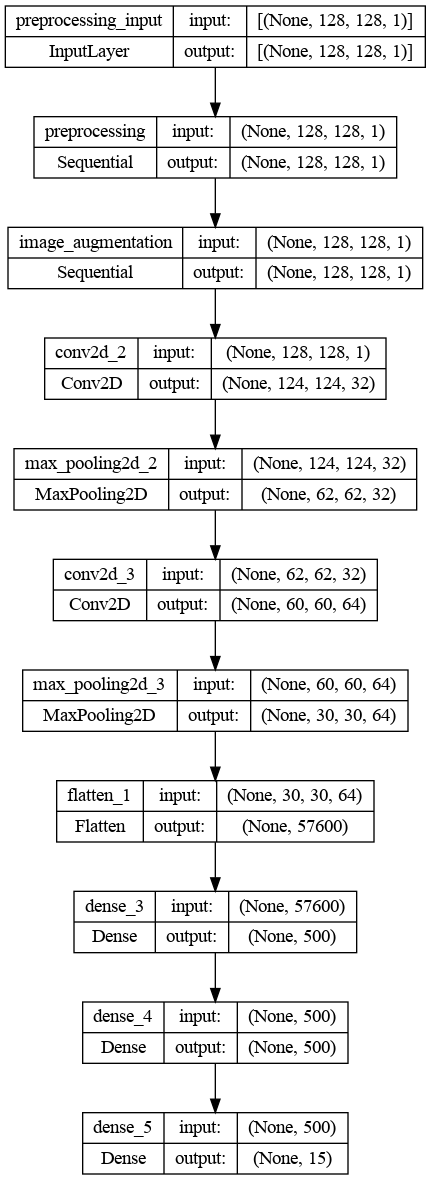

In [31]:
simple_CNN = Sequential([
    prep,
    image_augmentation,
    Conv2D(32, (5, 5), activation='relu', input_shape=(None, 128, 128, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(500, activation='relu'),
    Dense(500, activation='relu'),
    Dense(15, activation='softmax')
])

# Compile the model
simple_CNN.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

simple_CNN_history["With IA, With CW"] = fit_model_with_CW(simple_CNN, large_train, large_validation, large_test)

Epoch 1/50
283/283 [==============================] - 6s 18ms/step - loss: 2.5890 - accuracy: 0.1324 - val_loss: 2.3229 - val_accuracy: 0.2290
Epoch 2/50
283/283 [==============================] - 5s 17ms/step - loss: 2.2146 - accuracy: 0.2613 - val_loss: 1.9955 - val_accuracy: 0.3427
Epoch 3/50
283/283 [==============================] - 5s 17ms/step - loss: 1.9389 - accuracy: 0.3499 - val_loss: 1.7348 - val_accuracy: 0.4133
Epoch 4/50
283/283 [==============================] - 5s 18ms/step - loss: 1.6969 - accuracy: 0.4296 - val_loss: 1.7909 - val_accuracy: 0.4120
Epoch 5/50
283/283 [==============================] - 5s 18ms/step - loss: 1.5149 - accuracy: 0.4838 - val_loss: 1.8686 - val_accuracy: 0.4213
Epoch 6/50
283/283 [==============================] - 5s 18ms/step - loss: 1.3389 - accuracy: 0.5409 - val_loss: 1.2241 - val_accuracy: 0.5997
Epoch 7/50
283/283 [==============================] - 5s 17ms/step - loss: 1.2397 - accuracy: 0.5817 - val_loss: 1.0878 - val_accuracy: 0.6200

In [32]:
simple_CNN_history.pop("With IA")

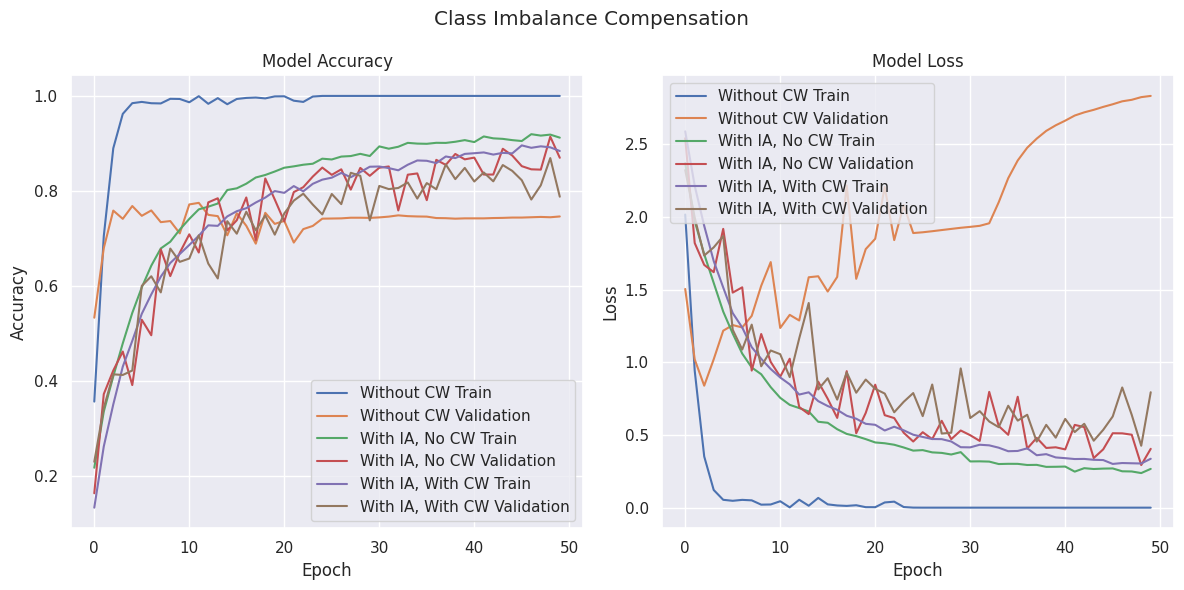

In [33]:
plot_history(simple_CNN_history, "Class Imbalance Compensation")

In terms of both loss and accuracy, using image augmentation without class weights performs better compared to with class weights.
Both models using image augmentation performs better than without image augmentation.

## Simple CNN (Base Model)
2x Convolution Blocks

In [39]:
simple_CNN.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocessing (Sequential)  (None, 128, 128, 1)       0         
                                                                 
 image_augmentation (Sequen  (None, 128, 128, 1)       0         
 tial)                                                           
                                                                 
 conv2d_12 (Conv2D)          (None, 124, 124, 32)      832       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 62, 62, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 30, 30, 64)       

Without Data Augmentation, the model starts overfitting very quickly and validation loss diverges over time while training loss converges.
With Data Augmentation, the model train and validation accuracies increase steadily while train and validation loss decrease over time.

In [42]:
simple_CNN_history.pop("Without Image Augmentation")

In [43]:
simple_CNN_history

{'With Image Augmentation': <keras.src.callbacks.History at 0x7fb1f2086e00>}

# Model Improvement
In this section I will implement, evaluate, and compare different techniques to improve the Image Classification Model.
* Architecture Modifications:
    * Deeper or Wider Network
    * Batch Normalization Layers
    * Dropout Layers
* Optimizer (Optimizing Optimizers with Optimal Optimization Optimizations):
    * Learning Rate Scheduling
<!-- * Custom Loss Functions -->
* Regularization
    * L1/L2
    * Weight Decay

### More Convolutional Blocks, More Convolutional Layers per Block, and Increasing Kernel Count with each Block

A convolutional block consists of one or more convolutional layers (filters are applied to the image to extract features such as edges, textures, and shapes), where the output is  passed through one or more pooling layers, which are used to down-sample the feature map. (Dimensional reduction and reduces the risk of overfitting)

Increasing the number of convolutional blocks and number of layers per block allow improved feature learning. Earlier layers learn simpler patterns while later (deeper) layers learn more complex features.

Increasing Kernel count with each Block, eg. 32 -> 64 -> 128 -> etc. also serves the same purpose, capturing more complex and abstract features and preventing the loss of data due to pooling.


In [35]:
simple_CNN_history = {"2x Block 1x Layer": simple_CNN_history["With IA, No CW"]}

In [37]:
simple_CNN_4_block = Sequential([
    prep,
    image_augmentation,
    Conv2D(32, (5, 5), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(500, activation='relu'),
    Dense(500, activation='relu'),
    Dense(15, activation='softmax')
])

# Compile the model
simple_CNN_4_block.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

simple_CNN_history["4x Block 1x Layer"] = fit_model(simple_CNN_4_block, large_train, large_validation, large_test)

Epoch 1/50
283/283 [==============================] - 7s 17ms/step - loss: 2.5970 - accuracy: 0.1165 - val_loss: 2.4900 - val_accuracy: 0.1800
Epoch 2/50
283/283 [==============================] - 4s 15ms/step - loss: 2.2809 - accuracy: 0.2271 - val_loss: 2.2930 - val_accuracy: 0.2210
Epoch 3/50
283/283 [==============================] - 4s 15ms/step - loss: 2.0717 - accuracy: 0.3043 - val_loss: 2.1050 - val_accuracy: 0.2940
Epoch 4/50
283/283 [==============================] - 4s 15ms/step - loss: 1.7742 - accuracy: 0.4095 - val_loss: 1.6683 - val_accuracy: 0.4373
Epoch 5/50
283/283 [==============================] - 4s 14ms/step - loss: 1.4609 - accuracy: 0.5041 - val_loss: 1.9757 - val_accuracy: 0.3800
Epoch 6/50
283/283 [==============================] - 4s 15ms/step - loss: 1.2579 - accuracy: 0.5764 - val_loss: 1.0780 - val_accuracy: 0.6367
Epoch 7/50
283/283 [==============================] - 4s 15ms/step - loss: 1.0517 - accuracy: 0.6453 - val_loss: 1.2511 - val_accuracy: 0.5977

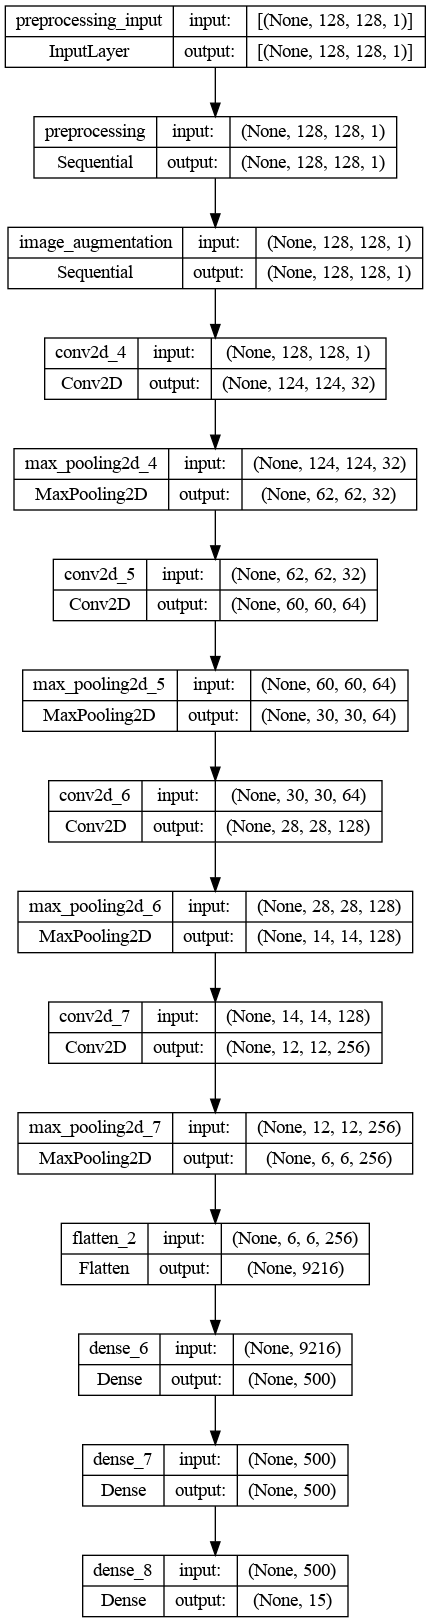

In [38]:
simple_CNN_4_block.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocessing (Sequential)  (None, 128, 128, 1)       0         
                                                                 
 sequential_4 (Sequential)   (None, 128, 128, 1)       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 124, 124, 32)      832       
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 62, 62, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 30, 30, 64)        0         
 ng2D)                                                

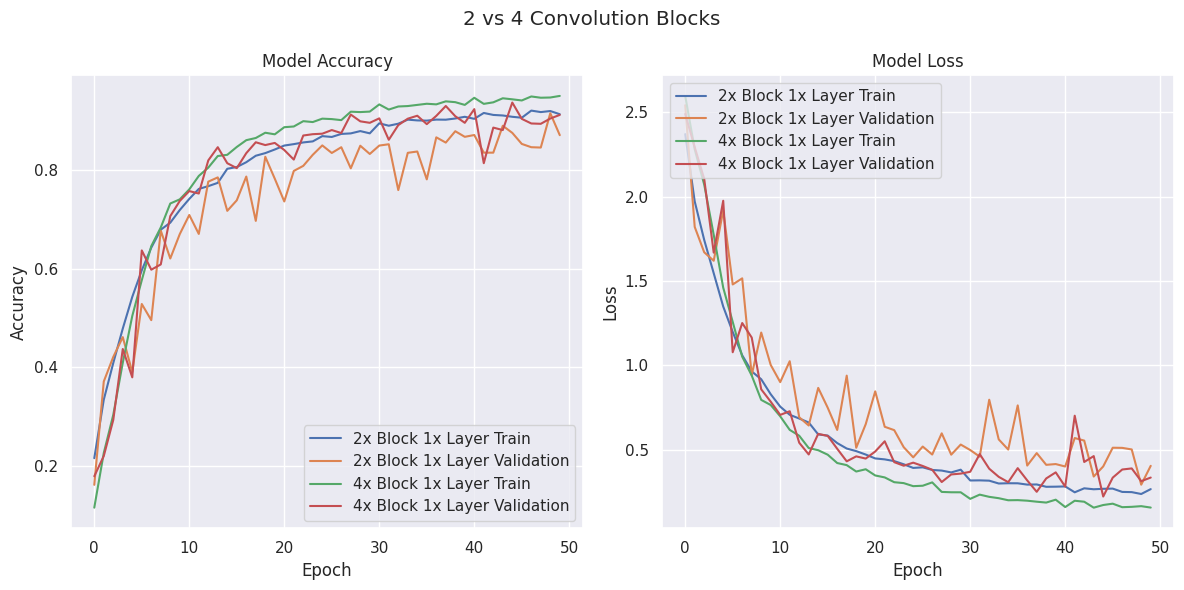

In [39]:
plot_history(simple_CNN_history, "2 vs 4 Convolution Blocks", savefig="images/2 vs 4 Convolution Blocks.png")

In [40]:
simple_CNN_4_block_2_layer = Sequential([
    prep,
    image_augmentation,
    Conv2D(32, (5, 5), activation='relu'),
    Conv2D(32, (5, 5), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(1000, activation='relu'),
    Dense(500, activation='relu'),
    Dense(15, activation='softmax')
])

# Compile the model
simple_CNN_4_block_2_layer.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

simple_CNN_history["4x Block 2x Layer"] = fit_model(simple_CNN_4_block_2_layer, large_train, large_validation, large_test)

Epoch 1/50
283/283 [==============================] - 10s 26ms/step - loss: 2.6518 - accuracy: 0.0989 - val_loss: 2.8076 - val_accuracy: 0.0667
Epoch 2/50
283/283 [==============================] - 7s 24ms/step - loss: 2.6401 - accuracy: 0.1032 - val_loss: 2.8014 - val_accuracy: 0.0667
Epoch 3/50
283/283 [==============================] - 7s 24ms/step - loss: 2.6390 - accuracy: 0.1035 - val_loss: 2.7834 - val_accuracy: 0.0667
Epoch 4/50
283/283 [==============================] - 7s 24ms/step - loss: 2.6380 - accuracy: 0.1007 - val_loss: 2.7679 - val_accuracy: 0.0667
Epoch 5/50
283/283 [==============================] - 7s 24ms/step - loss: 2.6379 - accuracy: 0.1030 - val_loss: 2.7820 - val_accuracy: 0.0667
Epoch 6/50
283/283 [==============================] - 7s 24ms/step - loss: 2.6378 - accuracy: 0.1047 - val_loss: 2.7853 - val_accuracy: 0.0667
Epoch 7/50
283/283 [==============================] - 7s 24ms/step - loss: 2.6377 - accuracy: 0.1040 - val_loss: 2.7709 - val_accuracy: 0.066

The model does not seem to be improving after 3 epochs. Since the model became much deeper and increased in complexity, I will decrease the learning rate.

In [41]:
simple_CNN_4_block_2_layer = Sequential([
    prep,
    image_augmentation,
    Conv2D(32, (3, 3), activation='relu'),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    Conv2D(512, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(3000, activation='relu'),
    Dense(2000, activation='relu'),
    Dense(15, activation='softmax')
])

# Compile the model
simple_CNN_4_block_2_layer.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

simple_CNN_history["4x Block 2x Layer"] = fit_model(simple_CNN_4_block_2_layer, large_train, large_validation, large_test, batch_size=128)

Epoch 1/50
71/71 [==============================] - 12s 98ms/step - loss: 2.6600 - accuracy: 0.1039 - val_loss: 2.7750 - val_accuracy: 0.0667
Epoch 2/50
71/71 [==============================] - 5s 71ms/step - loss: 2.6233 - accuracy: 0.1056 - val_loss: 2.7681 - val_accuracy: 0.0710
Epoch 3/50
71/71 [==============================] - 5s 70ms/step - loss: 2.5927 - accuracy: 0.1166 - val_loss: 2.7033 - val_accuracy: 0.1073
Epoch 4/50
71/71 [==============================] - 5s 70ms/step - loss: 2.4702 - accuracy: 0.1560 - val_loss: 2.8193 - val_accuracy: 0.0830
Epoch 5/50
71/71 [==============================] - 5s 69ms/step - loss: 2.4155 - accuracy: 0.1681 - val_loss: 2.4541 - val_accuracy: 0.1667
Epoch 6/50
71/71 [==============================] - 5s 70ms/step - loss: 2.3409 - accuracy: 0.2023 - val_loss: 2.7569 - val_accuracy: 0.0933
Epoch 7/50
71/71 [==============================] - 5s 70ms/step - loss: 2.3305 - accuracy: 0.1996 - val_loss: 2.4930 - val_accuracy: 0.1337
Epoch 8/50
7

In [42]:
simple_CNN_4_block_2_layer.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocessing (Sequential)  (None, 128, 128, 1)       0         
                                                                 
 sequential_4 (Sequential)   (None, 128, 128, 1)       0         
                                                                 
 conv2d_28 (Conv2D)          (None, 126, 126, 32)      320       
                                                                 
 conv2d_29 (Conv2D)          (None, 124, 124, 32)      9248      
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 62, 62, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_30 (Conv2D)          (None, 60, 60, 64)        18496     
                                                     

**Observations**
* The model may be too complex, another experimenting with multiple variations I am unable to get a suitable model architecture/learning rate combination. Thus I will move forward using only one convolutional layer per block.

## Overfitting Prevention Measures
* Dropout
* Batch Normalization (Does not directly prevent overfitting but has a slight regularization effect)
* L1 and L2 Regularization <br>
[Drop and Batch Normalization Ordering](https://stackoverflow.com/questions/39691902/ordering-of-batch-normalization-and-dropout)

In [43]:
overfitting_prevention_history = {}

In [71]:
CNN_dropout = Sequential([
    prep,
    image_augmentation,
    Conv2D(32, (5, 5), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    Flatten(),
    Dense(500, activation='relu'),
    Dropout(0.3),
    Dense(500, activation='relu'),
    Dropout(0.3),
    Dense(15, activation='softmax')
])

lr_schedule = ExponentialDecay(
    initial_learning_rate=0.0005,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True
)

# Compile the model
CNN_dropout.compile(optimizer=Adam(learning_rate=lr_schedule), loss='categorical_crossentropy', metrics=['accuracy'])

overfitting_prevention_history["Dropout"] = fit_model(CNN_dropout, large_train, large_validation, large_test)

Epoch 1/50
283/283 [==============================] - 6s 17ms/step - loss: 2.6114 - accuracy: 0.0991 - val_loss: 2.6381 - val_accuracy: 0.0850
Epoch 2/50
283/283 [==============================] - 5s 16ms/step - loss: 2.4232 - accuracy: 0.1595 - val_loss: 2.3078 - val_accuracy: 0.2380
Epoch 3/50
283/283 [==============================] - 5s 16ms/step - loss: 2.2026 - accuracy: 0.2563 - val_loss: 2.0428 - val_accuracy: 0.3087
Epoch 4/50
283/283 [==============================] - 5s 16ms/step - loss: 1.9621 - accuracy: 0.3356 - val_loss: 1.8190 - val_accuracy: 0.3867
Epoch 5/50
283/283 [==============================] - 5s 16ms/step - loss: 1.7092 - accuracy: 0.4177 - val_loss: 1.6455 - val_accuracy: 0.4353
Epoch 6/50
283/283 [==============================] - 5s 16ms/step - loss: 1.5371 - accuracy: 0.4778 - val_loss: 1.4756 - val_accuracy: 0.4983
Epoch 7/50
283/283 [==============================] - 5s 16ms/step - loss: 1.4110 - accuracy: 0.5222 - val_loss: 1.3962 - val_accuracy: 0.5107

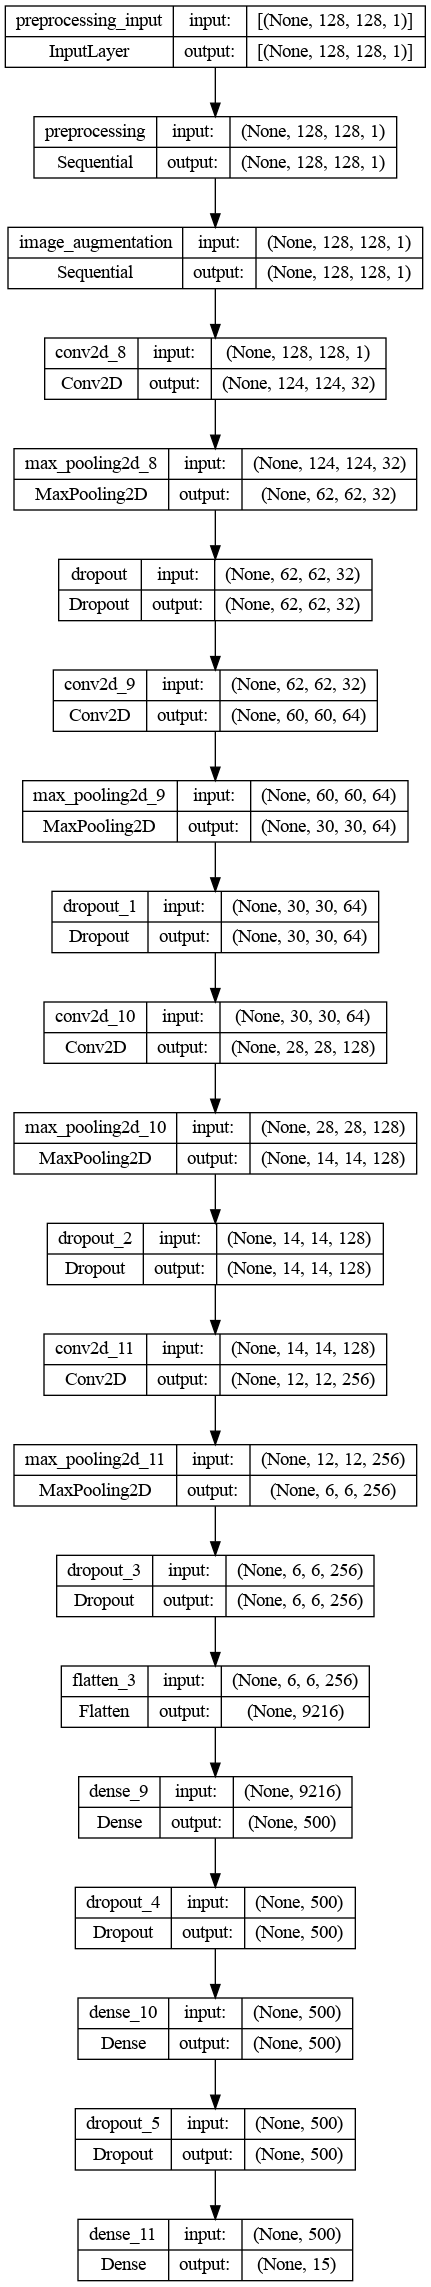

In [45]:
CNN_BN = Sequential([
    prep,
    image_augmentation,
    Conv2D(32, (5, 5), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Flatten(),
    Dense(500, activation='relu'),
    Dropout(0.3),
    Dense(500, activation='relu'),
    Dropout(0.3),
    Dense(15, activation='softmax')
])

lr_schedule = ExponentialDecay(
    initial_learning_rate=0.0005,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True
)

# Compile the model
CNN_BN.compile(optimizer=Adam(learning_rate=lr_schedule), loss='categorical_crossentropy', metrics=['accuracy'])

overfitting_prevention_history["BN"] = fit_model(CNN_BN, large_train, large_validation, large_test)

Epoch 1/50
283/283 [==============================] - 6s 17ms/step - loss: 2.3041 - accuracy: 0.3315 - val_loss: 5.5633 - val_accuracy: 0.0970
Epoch 2/50
283/283 [==============================] - 5s 16ms/step - loss: 1.6145 - accuracy: 0.4874 - val_loss: 2.8952 - val_accuracy: 0.2597
Epoch 3/50
283/283 [==============================] - 5s 16ms/step - loss: 1.3490 - accuracy: 0.5637 - val_loss: 13.3596 - val_accuracy: 0.0900
Epoch 4/50
283/283 [==============================] - 4s 16ms/step - loss: 1.1796 - accuracy: 0.6197 - val_loss: 13.1534 - val_accuracy: 0.1220
Epoch 5/50
283/283 [==============================] - 4s 15ms/step - loss: 1.0232 - accuracy: 0.6686 - val_loss: 2.0846 - val_accuracy: 0.4457
Epoch 6/50
283/283 [==============================] - 4s 16ms/step - loss: 0.9457 - accuracy: 0.6917 - val_loss: 5.1305 - val_accuracy: 0.2300
Epoch 7/50
283/283 [==============================] - 5s 16ms/step - loss: 0.8349 - accuracy: 0.7274 - val_loss: 2.7400 - val_accuracy: 0.39

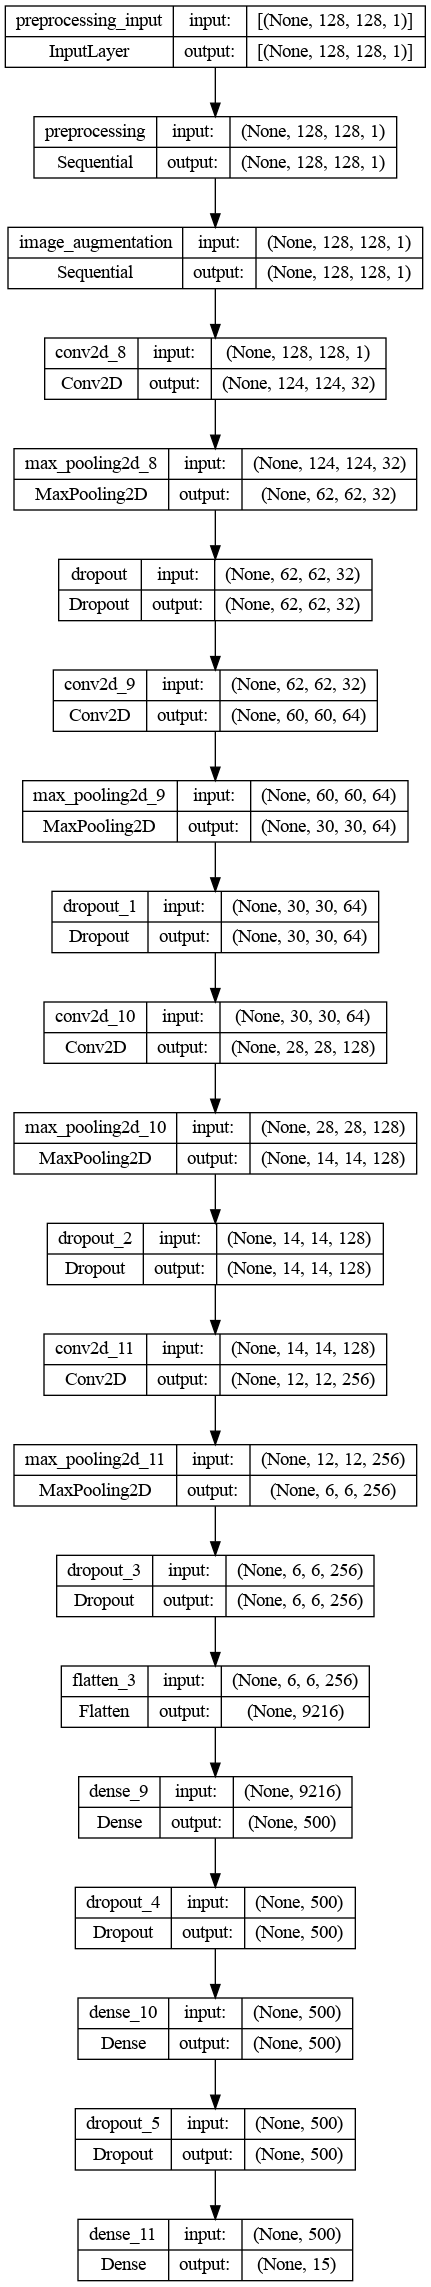

In [46]:
CNN_l2 = Sequential([
    prep,
    image_augmentation,
    Conv2D(32, (5, 5), activation='relu', kernel_regularizer="l2"),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer="l2"),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer="l2"),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu', kernel_regularizer="l2"),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(500, activation='relu'),
    Dropout(0.3),
    Dense(500, activation='relu'),
    Dropout(0.3),
    Dense(15, activation='softmax')
])

# Compile the model
CNN_l2.compile(optimizer=Adam(learning_rate=2e-4), loss='categorical_crossentropy', metrics=['accuracy'])

overfitting_prevention_history["l2"] = fit_model(CNN_l2, large_train, large_validation, large_test)

Epoch 1/50
283/283 [==============================] - 6s 16ms/step - loss: 3.5722 - accuracy: 0.1035 - val_loss: 3.0912 - val_accuracy: 0.0750
Epoch 2/50
283/283 [==============================] - 4s 15ms/step - loss: 2.6135 - accuracy: 0.1501 - val_loss: 2.6308 - val_accuracy: 0.1360
Epoch 3/50
283/283 [==============================] - 4s 15ms/step - loss: 2.3463 - accuracy: 0.2441 - val_loss: 2.5970 - val_accuracy: 0.1887
Epoch 4/50
283/283 [==============================] - 4s 15ms/step - loss: 2.2050 - accuracy: 0.2888 - val_loss: 2.4645 - val_accuracy: 0.2020
Epoch 5/50
283/283 [==============================] - 4s 15ms/step - loss: 2.1210 - accuracy: 0.3151 - val_loss: 2.1987 - val_accuracy: 0.2810
Epoch 6/50
283/283 [==============================] - 4s 16ms/step - loss: 2.0428 - accuracy: 0.3471 - val_loss: 2.4548 - val_accuracy: 0.2427
Epoch 7/50
283/283 [==============================] - 4s 16ms/step - loss: 1.9857 - accuracy: 0.3614 - val_loss: 2.3905 - val_accuracy: 0.2523

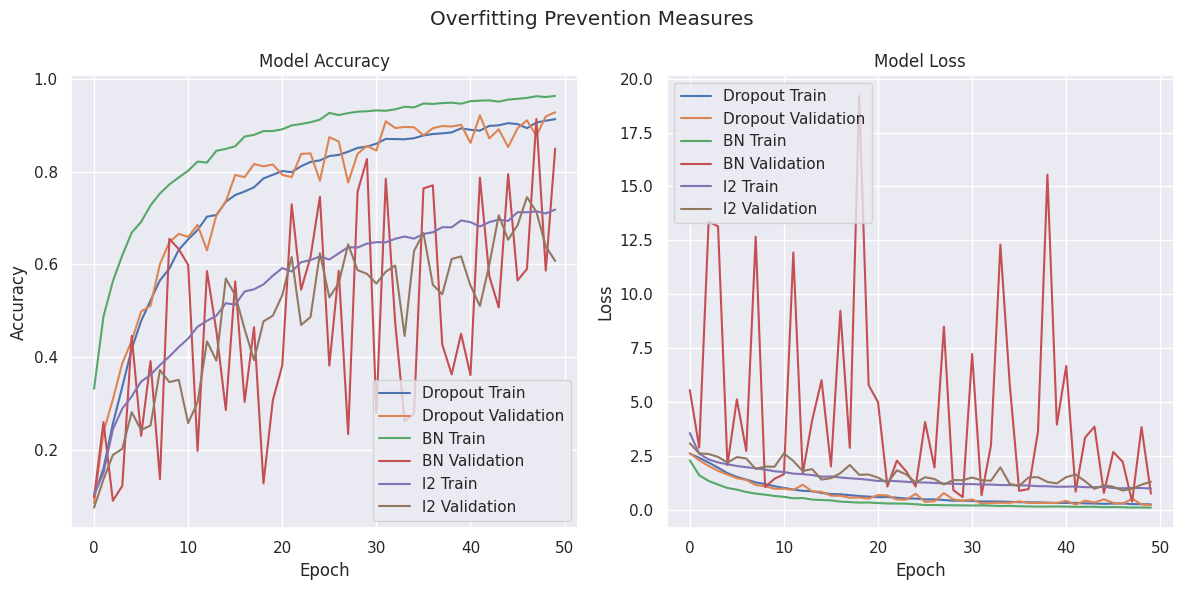

In [76]:
plot_history(overfitting_prevention_history, "Overfitting Prevention Measures", savefig="images/Overfitting Prevention Measures.png")

**Observations**
* Dropout produces good fits, no underfitting or overfitting, with low noise
* Dropout improves much faster than L2 regularization
* Batch Normalization produces very noisy validation accuracy and loss

## 31x31 Model

I have found that putting the image augmentation layer inside the model can cause big fluctuations between epochs so I will try to create augmented images before training, then populating them for each class for a certain target amount.

In [ ]:
small_train = train.map(resize_small)
small_validation = validation.map(resize_small)
small_test = test.map(resize_small)

In [38]:
# Access all images and labels
all_images = []
all_labels = []

for images, labels in small_train:
    all_images.append(images)
    all_labels.append(labels.numpy())

In [84]:
class_images = []

for image_class in list(range(15)):
    class_images.append([])
    for image, label in small_train:
        if np.argmax(label) == image_class:
            class_images[image_class].append(image)

In [91]:
target_qty_per_class = 1000
augmented_images = []
augmented_labels = []

for i in list(range(15)):
    original_idx = len(class_images[i])
    diff = target_qty_per_class - len(class_images[i])
    to_augments = []
    for _ in range(diff):
        rand_num = random.randint(0, original_idx-1)
        to_augments.append(class_images[i][rand_num])
    for to_augment in to_augments:
        augmented_images.append(image_augmentation(to_augment))
        augmented_labels.append(to_categorical(i, num_classes=15))
    print(len(augmented_images))

220
500
1059
1191
1441
1938
2587
3331
3744
3932
4366
4989
5175
5927
5972


In [92]:
augmented_dataset = tf.data.Dataset.from_tensor_slices((augmented_images, augmented_labels))
small_train_with_augmented = small_train.concatenate(augmented_dataset)

# Shuffle the combined dataset
small_train_with_augmented = small_train_with_augmented.shuffle(buffer_size=len(small_train_with_augmented))

In [93]:
small_CNN = {}

In [104]:
small_CNN_dropout = Sequential([
    prep,
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    Flatten(),
    Dense(250, activation='relu'),
    Dropout(0.2),
    Dense(250, activation='relu'),
    Dropout(0.2),
    Dense(15, activation='softmax')
])

# Compile the model
small_CNN_dropout.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor="loss",
    start_from_epoch=50,
    patience=5,
    min_delta=0.01,
    mode="min",
    restore_best_weights=True
)

lr_plateau = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    min_delta=0.01,
    verbose=1
)

small_CNN["dropout"] = fit_model(small_CNN_dropout, small_train_with_augmented, small_validation, small_test, epochs=50, filepath="training_checkpoints/small_CNN.{epoch:02d}-{val_accuracy:.2f}.h5", callbacks=[early_stopping, lr_plateau])

Epoch 1/50
467/469 [============================>.] - ETA: 0s - loss: 2.4554 - accuracy: 0.1650
Epoch 1: val_loss improved from inf to 2.13765, saving model to training_checkpoints/small_CNN.01-0.29.h5
469/469 [==============================] - 5s 7ms/step - loss: 2.4540 - accuracy: 0.1659 - val_loss: 2.1377 - val_accuracy: 0.2937 - lr: 0.0010
Epoch 2/50
460/469 [============================>.] - ETA: 0s - loss: 2.0473 - accuracy: 0.3277
Epoch 2: val_loss improved from 2.13765 to 1.66411, saving model to training_checkpoints/small_CNN.02-0.47.h5
469/469 [==============================] - 3s 6ms/step - loss: 2.0438 - accuracy: 0.3286 - val_loss: 1.6641 - val_accuracy: 0.4677 - lr: 0.0010
Epoch 3/50
459/469 [============================>.] - ETA: 0s - loss: 1.7409 - accuracy: 0.4304
Epoch 3: val_loss improved from 1.66411 to 1.23979, saving model to training_checkpoints/small_CNN.03-0.61.h5
469/469 [==============================] - 3s 6ms/step - loss: 1.7390 - accuracy: 0.4319 - val_los

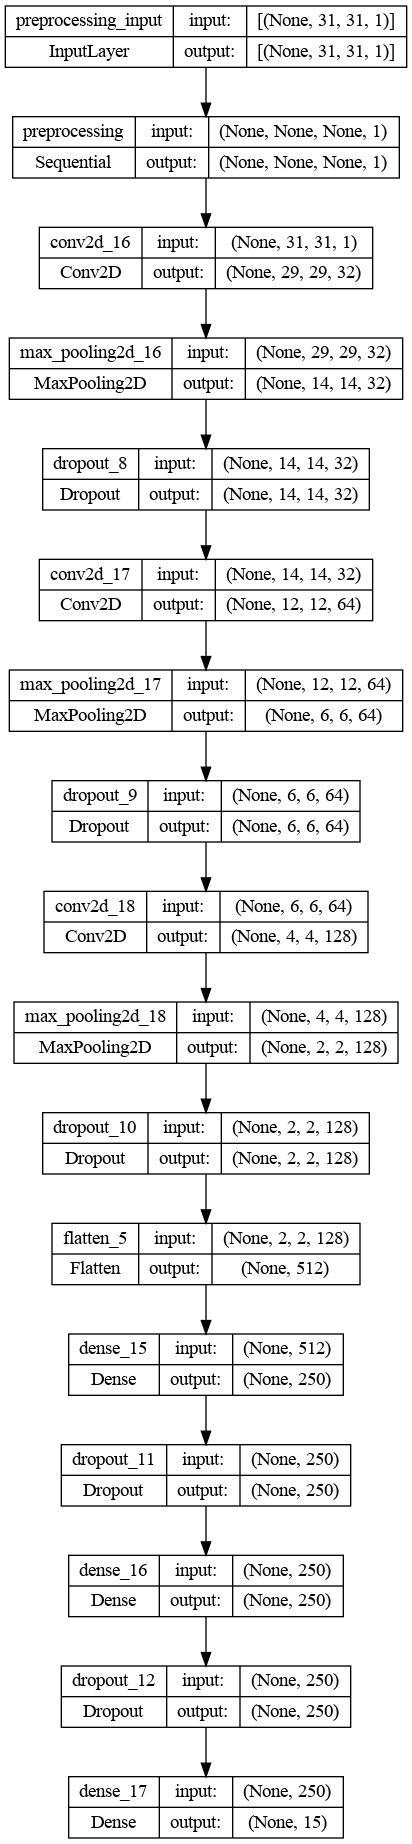

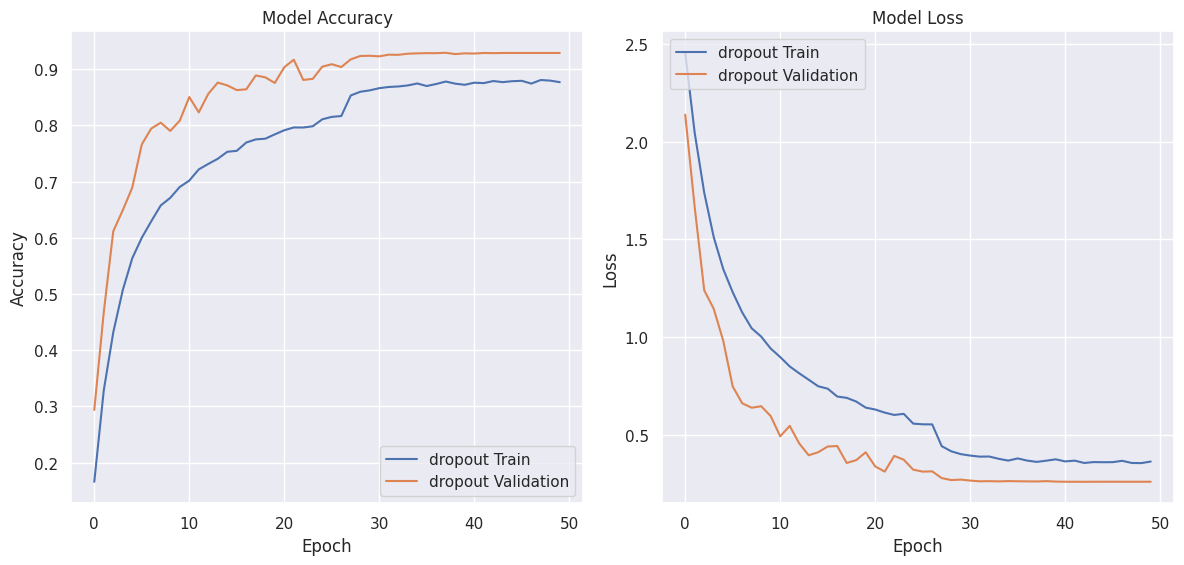

In [105]:
plot_history(small_CNN, title="")

In [99]:
small_CNN_dropout.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocessing (Sequential)  (None, 31, 31, 1)         0         
                                                                 
 conv2d_6 (Conv2D)           (None, 29, 29, 64)        640       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 14, 14, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 6, 6, 128)         0         
 g2D)                                                 

## Final Models
I will create my 128x128 and 31x31 models based on my findings above, approving them accordingly then using a high epoch count and early stopping to get my final models.

In [48]:
training_history = {}

In [77]:
CNN_dropout = Sequential([
    prep,
    image_augmentation,
    Conv2D(32, (5, 5), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    Flatten(),
    Dense(500, activation='relu'),
    Dropout(0.3),
    Dense(500, activation='relu'),
    Dropout(0.3),
    Dense(15, activation='softmax')
])

lr_schedule = ExponentialDecay(
    initial_learning_rate=0.0005,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True
)

# Compile the model
CNN_dropout.compile(optimizer=Adam(learning_rate=lr_schedule), loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor="loss",
    start_from_epoch=100,
    patience=3,
    min_delta=0.005,
    mode="min",
    restore_best_weights=True
)

training_history["128_dropout"] = fit_model(CNN_dropout, large_train, large_validation, large_test, epochs=200, filepath="training_checkpoints/CNN_dropout_clipnorm.{epoch:02d}-{val_accuracy:.2f}.h5", callbacks=[early_stopping])

Epoch 1/200
281/283 [============================>.] - ETA: 0s - loss: 2.6076 - accuracy: 0.0988
Epoch 1: val_loss improved from inf to 2.60813, saving model to training_checkpoints/CNN_dropout_clipnorm.01-0.11.h5
283/283 [==============================] - 6s 17ms/step - loss: 2.6072 - accuracy: 0.0994 - val_loss: 2.6081 - val_accuracy: 0.1087
Epoch 2/200
281/283 [============================>.] - ETA: 0s - loss: 2.3600 - accuracy: 0.1887
Epoch 2: val_loss improved from 2.60813 to 2.15083, saving model to training_checkpoints/CNN_dropout_clipnorm.02-0.25.h5
283/283 [==============================] - 5s 16ms/step - loss: 2.3603 - accuracy: 0.1887 - val_loss: 2.1508 - val_accuracy: 0.2527
Epoch 3/200
281/283 [============================>.] - ETA: 0s - loss: 2.0948 - accuracy: 0.2911
Epoch 3: val_loss improved from 2.15083 to 2.04617, saving model to training_checkpoints/CNN_dropout_clipnorm.03-0.29.h5
283/283 [==============================] - 5s 16ms/step - loss: 2.0936 - accuracy: 0.2

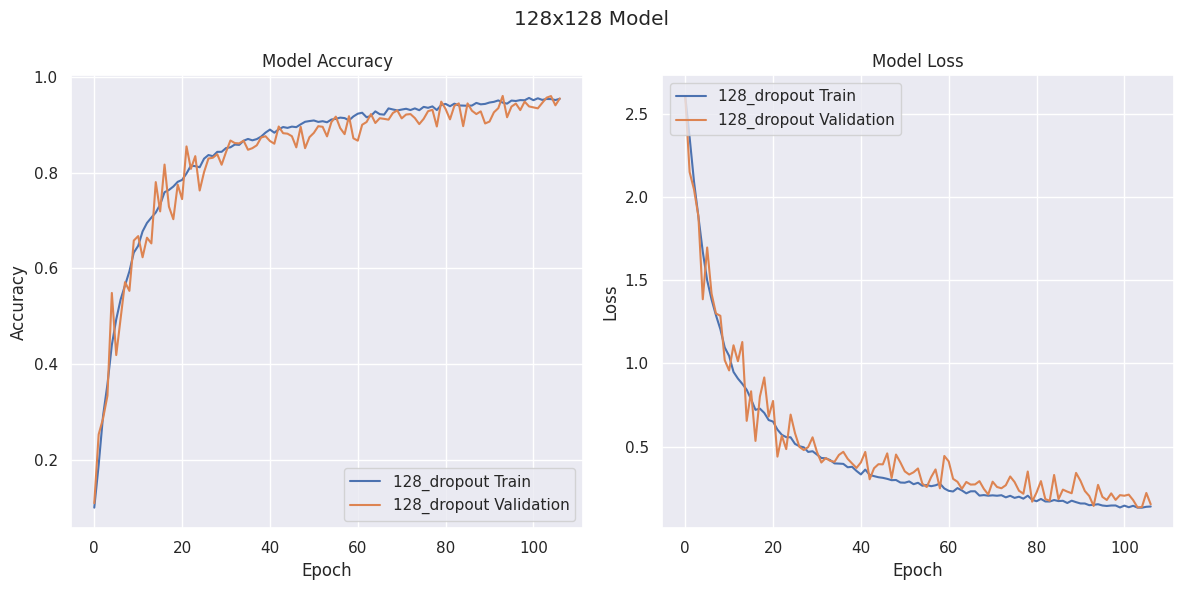

In [81]:
plot_history(training_history, title="128x128 Model")

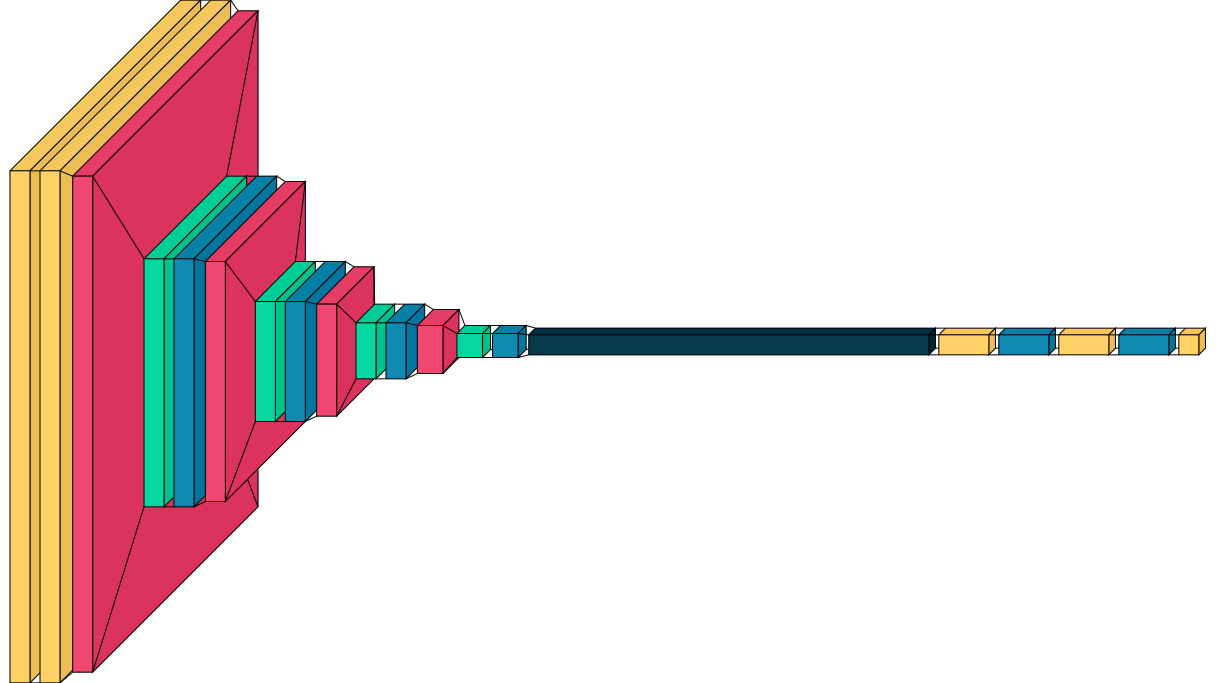

In [142]:
visualkeras.layered_view(CNN_dropout)

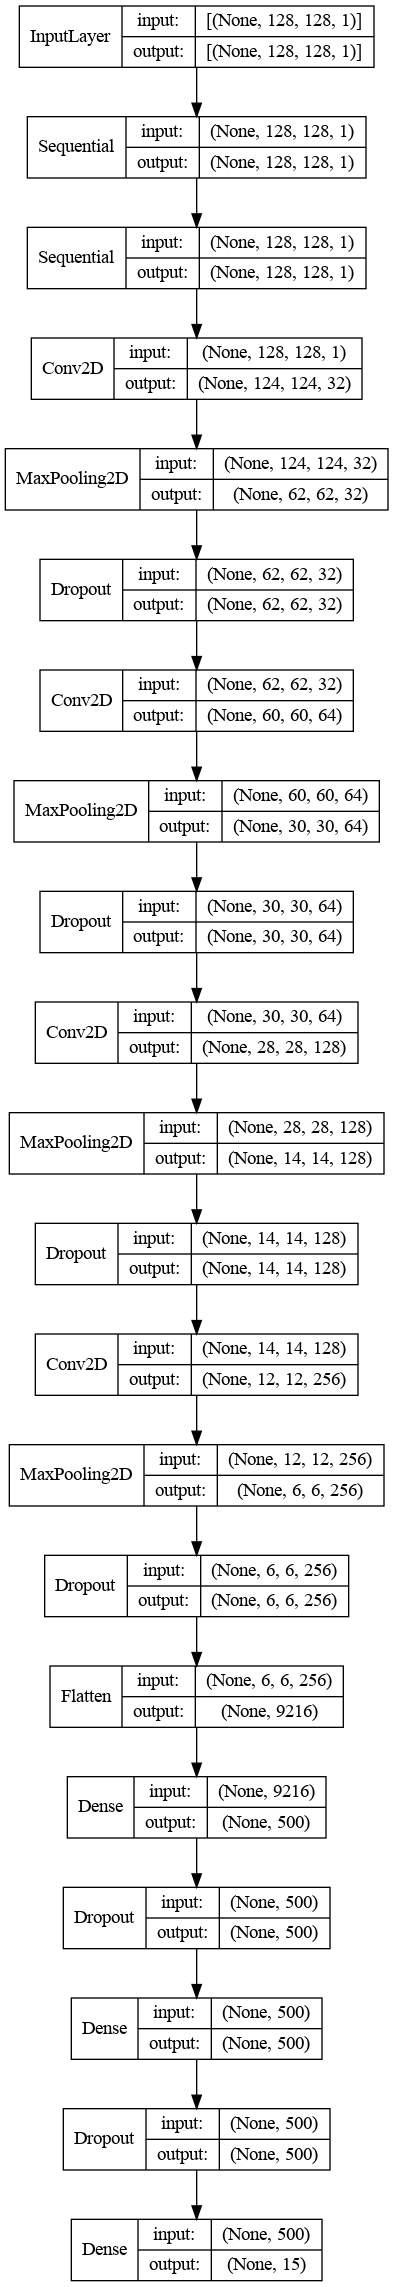

In [143]:
plot_model(CNN_dropout, show_shapes=True, show_layer_names=False)

In [85]:
CNN_dropout_clipnorm = Sequential([
    prep,
    image_augmentation,
    Conv2D(32, (5, 5), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    Flatten(),
    Dense(500, activation='relu'),
    Dropout(0.3),
    Dense(500, activation='relu'),
    Dropout(0.3),
    Dense(15, activation='softmax')
])

lr_schedule = ExponentialDecay(
    initial_learning_rate=0.0005,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True
)

# Compile the model
CNN_dropout_clipnorm.compile(optimizer=Adam(learning_rate=lr_schedule, clipnorm=2), loss='categorical_crossentropy', metrics=['accuracy'])

training_history["128_dropout_clipnorm"] = fit_model(CNN_dropout_clipnorm, large_train, large_validation, large_test, epochs=200, filepath="training_checkpoints/CNN_dropout_clipnorm.{epoch:02d}-{val_accuracy:.2f}.h5", callbacks=[early_stopping])

Epoch 1/200
280/283 [============================>.] - ETA: 0s - loss: 2.6371 - accuracy: 0.1083
Epoch 1: val_loss improved from inf to 2.65117, saving model to training_checkpoints/CNN_dropout_clipnorm.01-0.08.h5
283/283 [==============================] - 7s 18ms/step - loss: 2.6367 - accuracy: 0.1086 - val_loss: 2.6512 - val_accuracy: 0.0813
Epoch 2/200
280/283 [============================>.] - ETA: 0s - loss: 2.3907 - accuracy: 0.1944
Epoch 2: val_loss improved from 2.65117 to 2.33223, saving model to training_checkpoints/CNN_dropout_clipnorm.02-0.19.h5
283/283 [==============================] - 5s 18ms/step - loss: 2.3884 - accuracy: 0.1949 - val_loss: 2.3322 - val_accuracy: 0.1943
Epoch 3/200
281/283 [============================>.] - ETA: 0s - loss: 2.1578 - accuracy: 0.2671
Epoch 3: val_loss improved from 2.33223 to 1.98715, saving model to training_checkpoints/CNN_dropout_clipnorm.03-0.32.h5
283/283 [==============================] - 5s 17ms/step - loss: 2.1576 - accuracy: 0.2

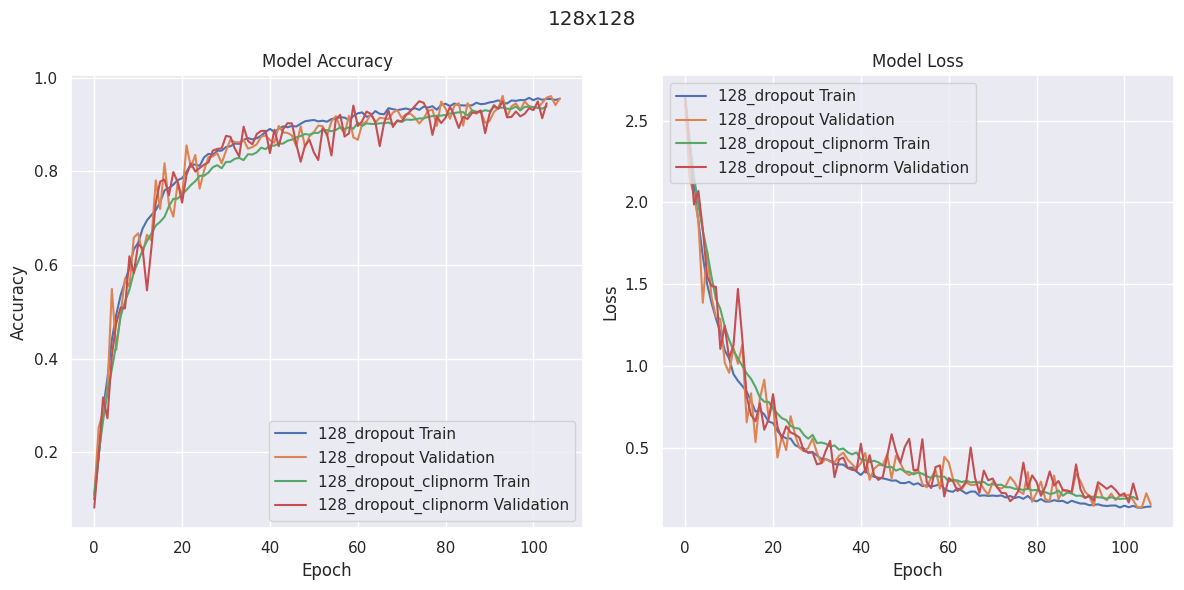

In [87]:
plot_history(training_history, "128x128")

Learning rate is already small enough that gradient clipping is not as useful.

## Model for Small Images (31x31)

In [94]:
small_CNN = {}

In [124]:
small_CNN_dropout = Sequential([
    prep,
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    Flatten(),
    Dense(400, activation='relu'),
    Dropout(0.3),
    Dense(400, activation='relu'),
    Dropout(0.3),
    Dense(15, activation='softmax')
])


lr_schedule = ExponentialDecay(
    initial_learning_rate=0.0015,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True
)

# Compile the model
small_CNN_dropout.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor="loss",
    start_from_epoch=50,
    patience=10,
    min_delta=0,
    mode="min",
    restore_best_weights=True
)

lr_plateau = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_delta=0.01,
    verbose=1
)

small_CNN["final"] = fit_model(small_CNN_dropout, small_train_with_augmented, small_validation, small_test, epochs=200, filepath="training_checkpoints/small_CNN_final.{epoch:02d}-{val_accuracy:.2f}.h5", callbacks=[early_stopping, lr_plateau])

Epoch 1/200
465/469 [============================>.] - ETA: 0s - loss: 2.5582 - accuracy: 0.1167
Epoch 1: val_loss improved from inf to 2.38280, saving model to training_checkpoints/small_CNN_final.01-0.22.h5
469/469 [==============================] - 4s 6ms/step - loss: 2.5568 - accuracy: 0.1173 - val_loss: 2.3828 - val_accuracy: 0.2200 - lr: 0.0010
Epoch 2/200
465/469 [============================>.] - ETA: 0s - loss: 2.2032 - accuracy: 0.2594
Epoch 2: val_loss improved from 2.38280 to 1.85890, saving model to training_checkpoints/small_CNN_final.02-0.44.h5
469/469 [==============================] - 4s 7ms/step - loss: 2.2021 - accuracy: 0.2596 - val_loss: 1.8589 - val_accuracy: 0.4443 - lr: 0.0010
Epoch 3/200
466/469 [============================>.] - ETA: 0s - loss: 1.9004 - accuracy: 0.3767
Epoch 3: val_loss improved from 1.85890 to 1.54604, saving model to training_checkpoints/small_CNN_final.03-0.49.h5
469/469 [==============================] - 4s 7ms/step - loss: 1.8998 - accur

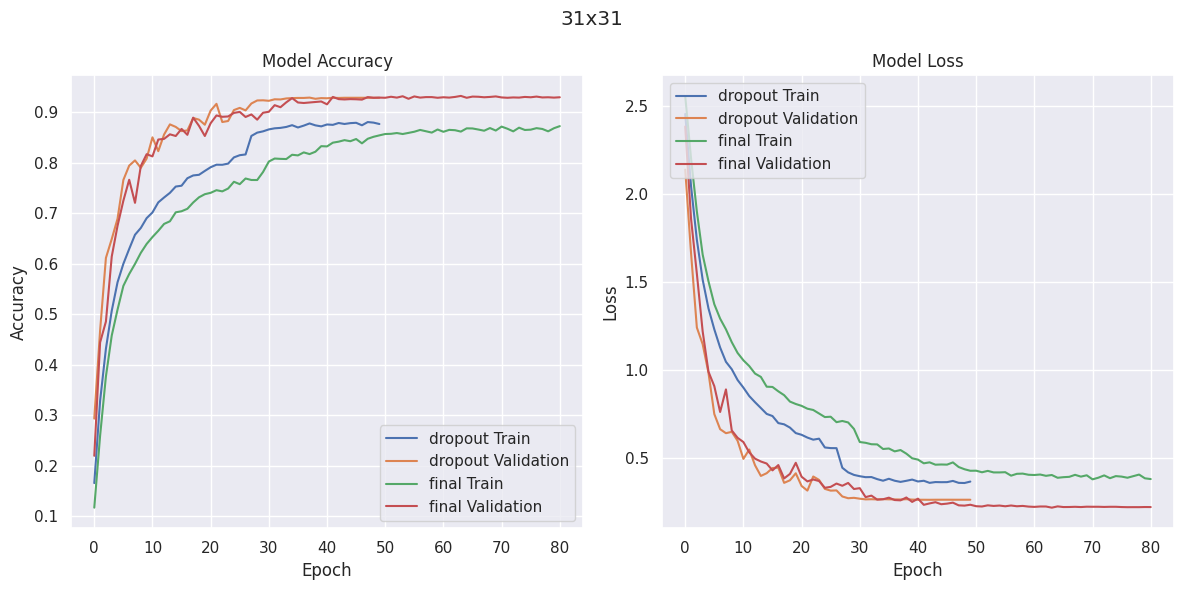

In [125]:
plot_history(small_CNN, "31x31")

In [127]:
small_CNN_dropout.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocessing (Sequential)  (None, 31, 31, 1)         0         
                                                                 
 conv2d_73 (Conv2D)          (None, 29, 29, 32)        320       
                                                                 
 max_pooling2d_73 (MaxPooli  (None, 14, 14, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_121 (Dropout)       (None, 14, 14, 32)        0         
                                                                 
 conv2d_74 (Conv2D)          (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_74 (MaxPooli  (None, 6, 6, 64)          0         
 ng2D)                                               

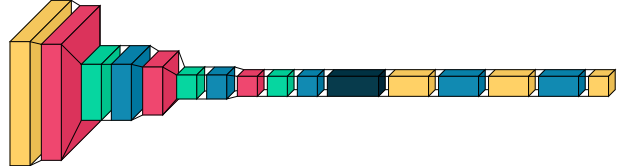

In [128]:
visualkeras.layered_view(small_CNN_dropout)

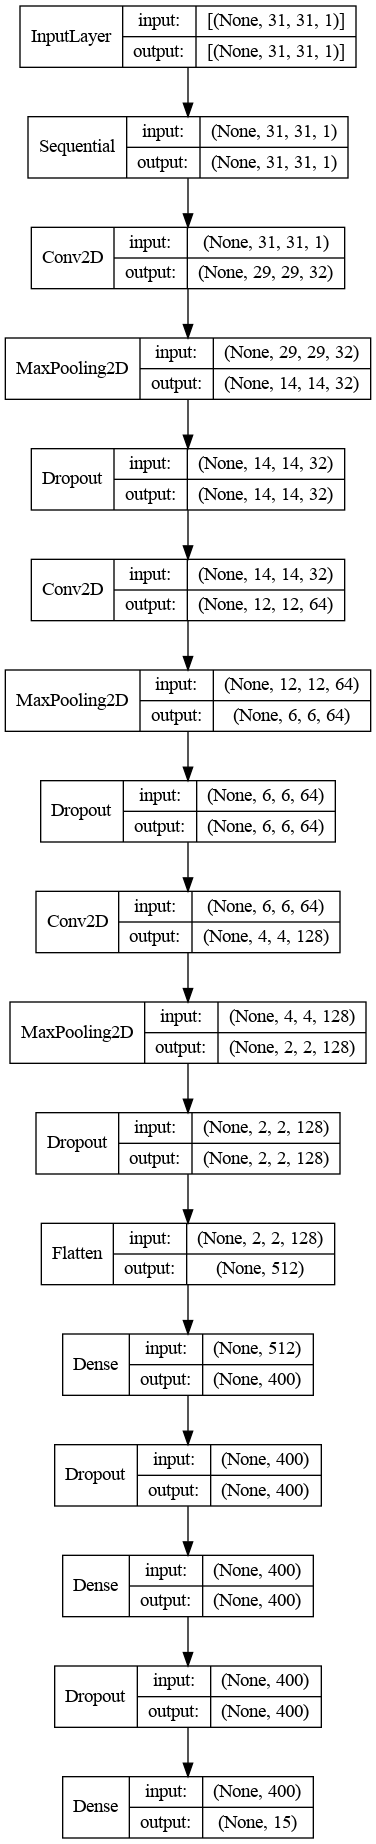

In [129]:
plot_model(small_CNN_dropout, show_shapes=True, show_layer_names=False)

## Final Results

In [198]:
final_large_CNN = Sequential([
    prep,
    image_augmentation,
    Conv2D(32, (5, 5), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    Flatten(),
    Dense(500, activation='relu'),
    Dropout(0.3),
    Dense(500, activation='relu'),
    Dropout(0.3),
    Dense(15, activation='softmax')
])

lr_schedule = ExponentialDecay(
    initial_learning_rate=0.0005,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True
)

final_large_CNN.compile(optimizer=Adam(learning_rate=lr_schedule), loss='categorical_crossentropy', metrics=['accuracy'])
final_large_CNN.build(input_shape=(None, 128, 128, 1))

final_large_CNN.load_weights("128_final.h5")

In [201]:
large_test_dataset = [(i, j) for i, j in large_test.batch(32)]

large_images = np.concatenate([i for i, j in large_test_dataset])
large_labels = np.concatenate([j for i, j in large_test_dataset])

predictions = final_large_CNN.predict(large_images)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(large_labels, axis=1)

print("Classification Report:\n", classification_report(true_labels, predicted_labels, target_names=list(class_keys.keys())))

94/94 [==============================] - 1s 6ms/step
Classification Report:
               precision    recall  f1-score   support

        Bean       0.95      0.99      0.97       200
Bitter_Gourd       0.97      0.95      0.96       200
Bottle_Gourd       0.98      0.98      0.98       200
     Brinjal       0.95      0.93      0.94       200
    Broccoli       0.94      0.97      0.96       200
     Cabbage       0.95      0.98      0.97       200
    Capsicum       0.93      0.95      0.94       200
      Carrot       0.95      0.98      0.96       200
 Cauliflower       0.99      0.94      0.97       200
    Cucumber       0.97      0.93      0.95       200
      Papaya       0.98      0.93      0.95       200
      Potato       1.00      0.94      0.97       200
     Pumpkin       0.98      0.94      0.96       200
      Radish       0.97      0.96      0.97       200
      Tomato       0.88      0.99      0.93       200

    accuracy                           0.96      3000
   

In [196]:
final_small_CNN = Sequential([
    prep,
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    Flatten(),
    Dense(400, activation='relu'),
    Dropout(0.3),
    Dense(400, activation='relu'),
    Dropout(0.3),
    Dense(15, activation='softmax')
])


final_small_CNN.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
final_small_CNN.build(input_shape=(None, 31, 31, 1))

final_small_CNN.load_weights("31_final.h5")

In [197]:
small_test_dataset = [(i, j) for i, j in small_test.batch(32)]

small_images = np.concatenate([i for i, j in small_test_dataset])
small_labels = np.concatenate([j for i, j in small_test_dataset])

predictions = final_small_CNN.predict(small_images)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(small_labels, axis=1)

print("Classification Report:\n", classification_report(true_labels, predicted_labels, target_names=list(class_keys.keys())))

94/94 [==============================] - 0s 2ms/step
Classification Report:
               precision    recall  f1-score   support

        Bean       0.95      0.95      0.95       200
Bitter_Gourd       0.96      0.94      0.95       200
Bottle_Gourd       0.98      0.98      0.98       200
     Brinjal       0.93      0.94      0.93       200
    Broccoli       0.88      0.97      0.92       200
     Cabbage       0.94      0.89      0.92       200
    Capsicum       0.98      0.96      0.97       200
      Carrot       0.98      0.93      0.95       200
 Cauliflower       0.88      0.95      0.92       200
    Cucumber       0.95      0.97      0.96       200
      Papaya       0.94      0.96      0.95       200
      Potato       0.92      0.93      0.93       200
     Pumpkin       0.95      0.93      0.94       200
      Radish       0.96      0.94      0.95       200
      Tomato       0.93      0.89      0.91       200

    accuracy                           0.94      3000
   

Information is lost when downscaling from 128x128 to 31x31, thus it can be expected that the 31x31 model would perform worse than 128x128. <br>
From both models, prediction of Tomatos performs the worst while Bitter Gourd prediction performs best.